We need to install the following required libraries to work with the FACS data.

Import everything that we will need.

In [ ]:
import FlowCytometryTools
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import FCPlate
from google.colab import files
import pandas as pd
import os
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.preprocessing import StandardScaler
import collections
from sklearn.utils import shuffle
from scipy import stats
from IPython.display import display
import seaborn as sns

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

pd.options.display.max_rows = 32
pd.options.display.float_format = '{:.5f}'.format

np.set_printoptions(threshold=np.inf)

TensorFlow 1.x selected.


Using TensorFlow backend.


Loading the created dataframe from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/date FACS/dataframeWithoutIndex.csv"

completeTrainingDataFrame = pd.read_csv(path)
completeTrainingDataFrame = completeTrainingDataFrame.drop(completeTrainingDataFrame.columns.difference(['FSC-A','SSC-A','isMonocyte']),1)
#completeTrainingDataFrame = completeTrainingDataFrame.drop(columns=['Violet SSC-H','Violet SSC-A','Time'])
#completeTrainingDataFrame = completeTrainingDataFrame.drop(columns=['FSC-H','SSC-H','FSC-Width'])

#completeTrainingDataFrame = ((completeTrainingDataFrame-completeTrainingDataFrame.min())/(completeTrainingDataFrame.max()-completeTrainingDataFrame.min()))

display(completeTrainingDataFrame.describe())
display(completeTrainingDataFrame.head(10))
display(completeTrainingDataFrame['FSC-A'].quantile(np.linspace(.1, 1, 40, 0)))
display(completeTrainingDataFrame['SSC-A'].quantile(np.linspace(.1, 1, 40, 0)))
completeTrainingDataFrame = completeTrainingDataFrame[completeTrainingDataFrame['FSC-A'] < 1100000]
completeTrainingDataFrame = completeTrainingDataFrame[completeTrainingDataFrame['SSC-A'] < 1000000]
display(completeTrainingDataFrame.describe())

Mounted at /content/drive


,FSC-A,SSC-A,isMonocyte
count,674846.00000,674846.00000,674846.00000
mean,418443.88466,292545.18496,0.21132
std,535622.19395,760166.38492,0.40825
min,32273.20000,-19771.10000,0.00000
25%,108104.62500,53393.72500,0.00000
50%,273357.35000,173204.75000,0.00000
75%,701655.55000,430340.77500,0.00000
max,85196570.00000,107005880.00000,1.00000


,FSC-A,SSC-A,isMonocyte
0,98368.30000,111628.90000,0
1,682416.80000,370041.30000,1
2,744135.90000,301506.50000,1
3,106809.60000,42598.30000,0
4,722312.20000,528407.40000,1
5,603061.00000,303170.60000,1
6,174413.40000,68691.30000,0
7,299239.10000,150394.10000,0
8,701685.10000,857271.40000,0
9,96891.70000,35934.70000,0


0.10000     89892.90000
0.12250     92128.75125
0.14500     94473.50000
0.16750     96950.65375
0.19000     99630.69500
               ...     
0.88750    808203.05000
0.91000    829836.59000
0.93250    856728.23500
0.95500    896232.69500
0.97750   1014906.53375
Name: FSC-A, Length: 40, dtype: float64

0.10000    36983.90000
0.12250    39200.75375
0.14500    41423.55750
0.16750    43712.45375
0.19000    46114.20000
              ...     
0.88750   621184.32500
0.91000   666156.00500
0.93250   720762.20500
0.95500   797010.47250
0.97750   943144.73750
Name: SSC-A, Length: 40, dtype: float64

,FSC-A,SSC-A,isMonocyte
count,657054.00000,657054.00000,657054.00000
mean,384895.55293,253586.29076,0.21705
std,295079.70309,231222.88249,0.41223
min,32273.20000,-19771.10000,0.00000
25%,107065.47500,52499.65000,0.00000
50%,240255.00000,156455.25000,0.00000
75%,685664.17500,410090.85000,0.00000
max,1099905.20000,999935.60000,1.00000


Exploratory Data Analysis

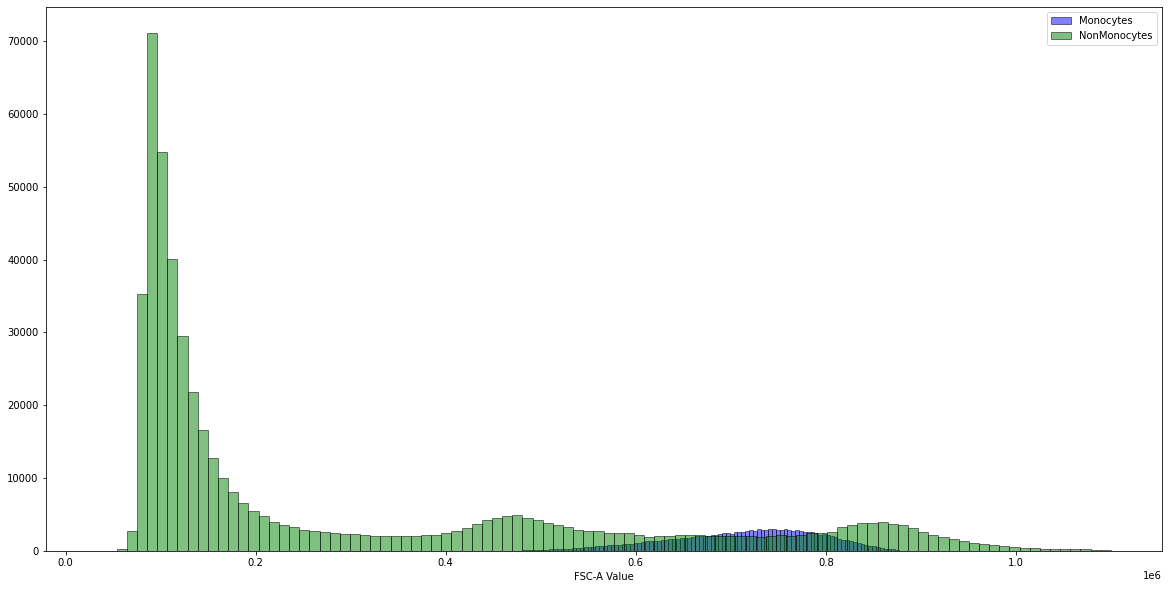

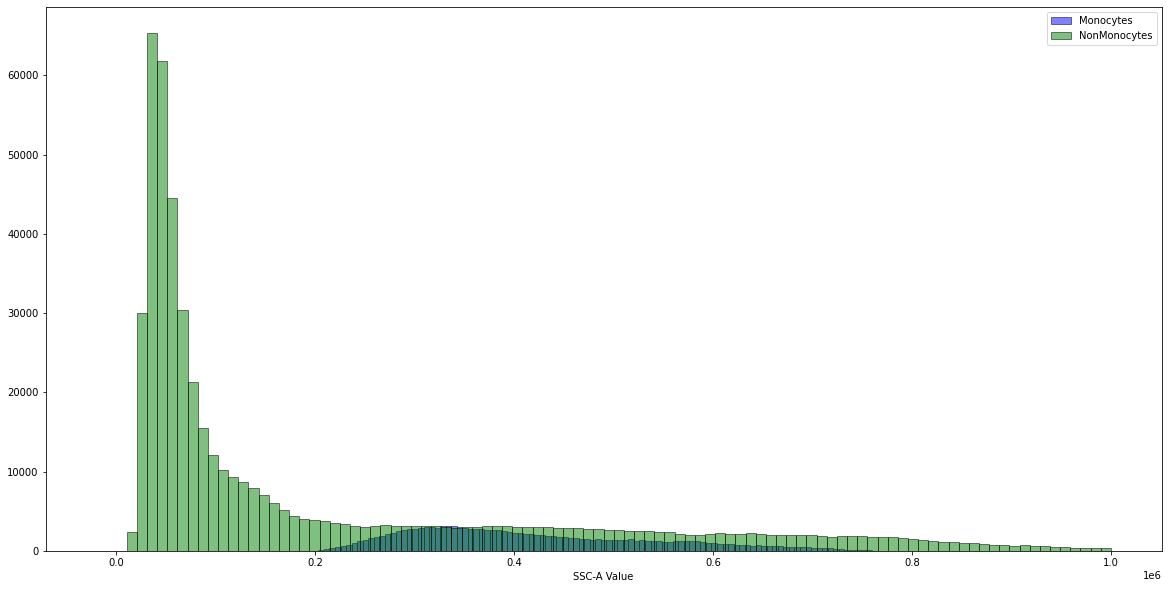

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(completeTrainingDataFrame['FSC-A'][completeTrainingDataFrame['isMonocyte']==1], bins=100, alpha=0.5, label='Monocytes', color='blue', edgecolor='black')
plt.hist(completeTrainingDataFrame['FSC-A'][completeTrainingDataFrame['isMonocyte']==0], bins=100, alpha=0.5, label='NonMonocytes', color='green',edgecolor='black')
plt.legend(loc='upper right')
plt.xlabel('FSC-A Value')
plt.show()

plt.figure(figsize=(20,10))
plt.hist(completeTrainingDataFrame['SSC-A'][completeTrainingDataFrame['isMonocyte']==1], bins=100, alpha=0.5, label='Monocytes', color='blue', edgecolor='black')
plt.hist(completeTrainingDataFrame['SSC-A'][completeTrainingDataFrame['isMonocyte']==0], bins=100, alpha=0.5, label='NonMonocytes', color='green', edgecolor='black')
plt.legend(loc='upper right')
plt.xlabel('SSC-A Value')
plt.show()

SNS Boxplots

<Figure size 1440x720 with 0 Axes>

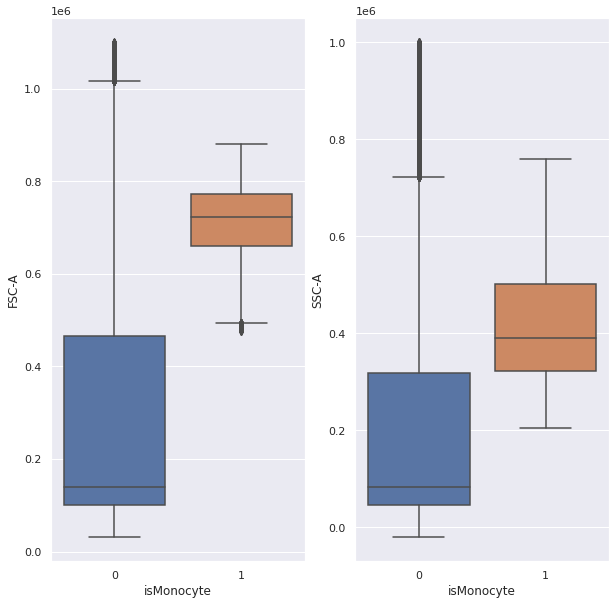

In [ ]:
plt.figure(figsize=(20,10))

fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(data=completeTrainingDataFrame, y='FSC-A', x='isMonocyte', ax=axs[0])
sns.boxplot(data=completeTrainingDataFrame, y='SSC-A', x='isMonocyte', ax=axs[1])

Separating the training dataset and the validation dataset

In [ ]:
def percentage(percent, whole):
  return int((percent * whole) / 100.0)

# Choose the first 80% (out of 657,053) examples for training.

dataframeSize = completeTrainingDataFrame['FSC-A'].count()
training_examples = completeTrainingDataFrame.head(percentage(80,dataframeSize))
training_examples = training_examples.drop(columns=['isMonocyte'])
training_targets = completeTrainingDataFrame['isMonocyte'].head(percentage(80,dataframeSize))

# Choose the last 20% (out of 657,053) examples for validation.
validation_examples = completeTrainingDataFrame.tail(percentage(20,dataframeSize))
validation_examples = validation_examples.drop(columns=['isMonocyte'])
validation_targets = completeTrainingDataFrame['isMonocyte'].tail(percentage(20,dataframeSize))

# Double-check that we've done the right thing.
print("Training examples summary:")
display(training_examples.describe())
print("Validation examples summary:")
display(validation_examples.describe())

print("Training targets summary:")
display(training_targets.describe())
display(validation_targets.describe())

Training examples summary:


,FSC-A,SSC-A
count,525643.00000,525643.00000
mean,384785.68917,253650.40522
std,294997.49257,231219.19730
min,32273.20000,-13964.70000
25%,107074.25000,52518.20000
50%,240078.30000,156436.10000
75%,685615.40000,410483.85000
max,1099905.20000,999935.60000


Validation examples summary:


,FSC-A,SSC-A
count,131410.00000,131410.00000
mean,385337.06033,253331.53522
std,295409.21692,231238.38157
min,48185.80000,-19771.10000
25%,107025.85000,52424.95000
50%,240979.60000,156523.85000
75%,685954.42500,408461.60000
max,1099871.80000,999904.40000


Training targets summary:


count   525643.00000
mean         0.21677
std          0.41205
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: isMonocyte, dtype: float64

count   131410.00000
mean         0.21815
std          0.41299
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: isMonocyte, dtype: float64

Function that plots the statistics from the cross validation .

In [ ]:
def plot_learning_curve(scores, title):
    _, axes = plt.subplots(1, 4, figsize=(25, 5))

    train_scores_accuracy = scores['train_accuracy']
    test_scores_accuracy = scores['test_accuracy']
    train_scores_precision = scores['train_precision']
    test_scores_precision = scores['test_precision']
    train_scores_recall = scores['train_recall']
    test_scores_recall = scores['test_recall']
    train_scores_f1 = scores['train_f1']
    test_scores_f1 = scores['test_f1']
    fit_times_mean = scores['fit_time']
    
    cv_model = np.linspace(1, 10, 10)

    # Plot learning curve
    axes[0].set_title(title + ' Accuracy')
    axes[0].set_xlabel("CV Model")
    axes[0].set_ylabel("Score")
    axes[0].grid()
    axes[0].plot(cv_model, train_scores_accuracy, 'o-', color="r",
                 label="Training Score Accuracy")
    axes[0].plot(cv_model, test_scores_accuracy, 'o-', color="g",
                 label="Testing Score Accuracy")
    axes[0].legend(loc="best")


    axes[1].set_title(title + ' Precision')
    axes[1].set_xlabel("CV Model")
    axes[1].set_ylabel("Score")
    axes[1].grid()
    axes[1].plot(cv_model, train_scores_precision, 'o-', color="r",
                 label="Training Score Precision")
    axes[1].plot(cv_model, test_scores_precision, 'o-', color="g",
                 label="Testing Score Precision")
    axes[1].legend(loc="best")

    axes[2].set_title(title + ' Recall')
    axes[2].set_xlabel("CV Model")
    axes[2].set_ylabel("Score")
    axes[2].grid()
    axes[2].plot(cv_model, train_scores_recall, 'o-', color="r",
                 label="Training Score Recall")
    axes[2].plot(cv_model, test_scores_recall, 'o-', color="g",
                 label="Testing Score Recall")
    axes[2].legend(loc="best")

    axes[3].set_title(title + ' F1')
    axes[3].set_xlabel("CV Model")
    axes[3].set_ylabel("Score")
    axes[3].grid()
    axes[3].plot(cv_model, train_scores_f1, 'o-', color="r",
                 label="Training Score F1")
    axes[3].plot(cv_model, test_scores_f1, 'o-', color="g",
                 label="Testing Score F1")
    axes[3].legend(loc="best")

    return plt

Function that trains models and tests them.

In [ ]:
def trainAndTestModel(model, modelName, completeTrainingDataFrame, training_examples, training_targets, validation_targets):

  features = completeTrainingDataFrame[['FSC-A','SSC-A']]
  label = completeTrainingDataFrame['isMonocyte']

  scores = cross_validate(model, features, label, cv=10, scoring=('accuracy', 'precision', 'recall', 'f1'), return_train_score=True)

  display('Cross validation ' + modelName + ' results:', scores)

  # Train the model using the training sets

  print(modelName + ' model testing metrics:')
  model.fit(training_examples, training_targets.values.ravel())

  validation_predictions = model.predict(validation_examples)

  # Accuracy: (TP + TN) / (P + N)
  accuracy = accuracy_score(validation_targets.values, validation_predictions)
  print('Accuracy: %f' % accuracy)

  # Precision TP / (TP + FP)
  precision = precision_score(validation_targets.values, validation_predictions)
  print('Precision: %f' % precision)

  # Recall: TP / (TP + FN)
  recall = recall_score(validation_targets.values, validation_predictions)
  print('Recall: %f' % recall)

  # F1: 2 TP / (2 TP + FP + FN)
  f1 = f1_score(validation_targets.values, validation_predictions)
  print('F1 score: %f' % f1)

  # Cohen Kappa
  kappa = cohen_kappa_score(validation_targets.values,  validation_predictions)
  print('Cohens kappa: %f' % kappa)

  # ROC AUC
  auc = roc_auc_score(validation_targets.values,  validation_predictions)
  print('ROC AUC: %f' % auc)
  
  # Confusion Matrix
  print('Confusion Matrix:')
  matrix = confusion_matrix(validation_targets.values,  validation_predictions)
  print(matrix)

  plot_learning_curve(scores, modelName)

  return model

K-Nearest Neighbors Model

'Cross validation K-Nearest Neighbors results:'

{'fit_time': array([0.57163811, 0.58344698, 0.57385683, 0.60440516, 0.73339081,
        0.55886984, 0.63475585, 0.60767603, 0.56876969, 0.69878125]),
 'score_time': array([1.95441747, 1.95051813, 1.96262932, 1.97592163, 1.96896982,
        1.96838069, 1.97873664, 1.94635773, 1.95645952, 1.95828581]),
 'test_accuracy': array([0.95476821, 0.95329194, 0.95524001, 0.95457036, 0.95449357,
        0.95364128, 0.95534586, 0.95440225, 0.95309337, 0.95251503]),
 'test_f1': array([0.89784835, 0.89403722, 0.89886172, 0.89761619, 0.8969392 ,
        0.89538398, 0.89898086, 0.89710832, 0.89400922, 0.89335521]),
 'test_precision': array([0.88053664, 0.88062849, 0.88196788, 0.87860068, 0.8820419 ,
        0.87748233, 0.88310898, 0.87911422, 0.87723561, 0.8714905 ]),
 'test_recall': array([0.91585443, 0.9078606 , 0.9164154 , 0.91747301, 0.91234836,
        0.91403127, 0.9154337 , 0.91585443, 0.91143679, 0.91634528]),
 'train_accuracy': array([0.96230308, 0.96235719, 0.96226418, 0.96244513, 0.9621222 ,

K-Nearest Neighbors model testing metrics:
Accuracy: 0.953580
Precision: 0.876631
Recall: 0.916141
F1 score: 0.895951
Cohens kappa: 0.866096
ROC AUC: 0.940084
Confusion Matrix:
[[99047  3696]
 [ 2404 26263]]


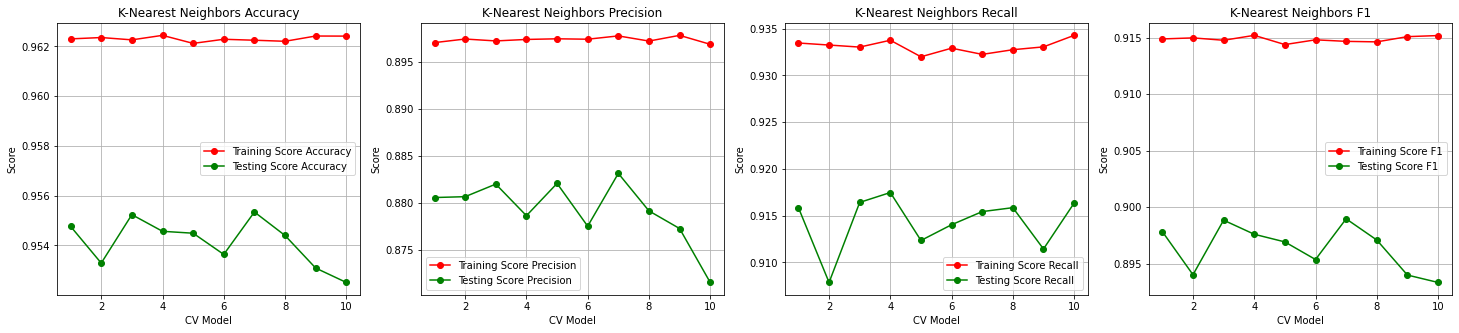

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

model = trainAndTestModel(model, 'K-Nearest Neighbors', completeTrainingDataFrame, training_examples, training_targets, validation_targets)

Random Forest Model

'Cross validation Random Forest results:'

{'fit_time': array([73.12154984, 72.55029869, 72.75550961, 72.45610881, 72.41620183,
        67.39775634, 65.02001429, 67.58941054, 65.22314405, 65.03056884]),
 'score_time': array([0.8462472 , 0.83419704, 0.83411193, 0.84621763, 0.84778523,
        0.83246827, 0.84738898, 0.83036518, 0.82788682, 0.84672379]),
 'test_accuracy': array([0.95336803, 0.95266795, 0.95335281, 0.95359632, 0.95370215,
        0.95211932, 0.95321513, 0.95367171, 0.95260635, 0.95187581]),
 'test_f1': array([0.89551221, 0.89373334, 0.89533891, 0.89623958, 0.89585758,
        0.89268659, 0.89501366, 0.89611631, 0.89366933, 0.89258051]),
 'test_precision': array([0.87167231, 0.87157614, 0.87260383, 0.87072671, 0.87524249,
        0.86914646, 0.87242826, 0.87288079, 0.87094842, 0.86570016]),
 'test_recall': array([0.9206928 , 0.91704649, 0.91929037, 0.92329267, 0.91746722,
        0.91753734, 0.91879952, 0.92062268, 0.91760746, 0.92118365]),
 'train_accuracy': array([0.99998985, 0.99999154, 0.99999154, 0.99999831, 0

Random Forest model testing metrics:
Accuracy: 0.952370
Precision: 0.869476
Recall: 0.919733
F1 score: 0.893899
Cohens kappa: 0.863223
ROC AUC: 0.940605
Confusion Matrix:
[[98785  3958]
 [ 2301 26366]]


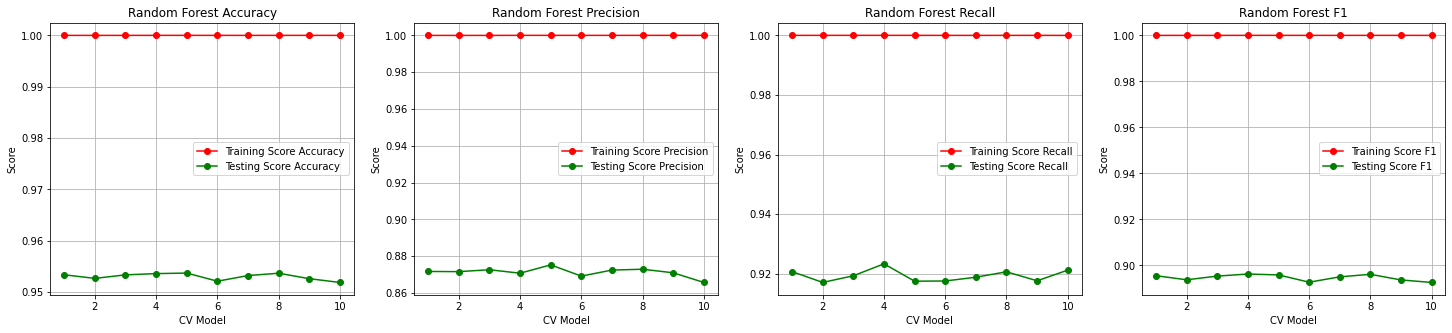

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

model = trainAndTestModel(model, 'Random Forest', completeTrainingDataFrame, training_examples, training_targets, validation_targets)

Support Vector Machines Model

'Cross validation Support Vector Machines results:'

{'fit_time': array([1439.06300783, 1414.15612602, 1433.39577413, 1537.79419398,
        1442.29298019, 1448.02129507, 1463.38508964, 1444.3165369 ,
        1416.12097692, 1492.35626435]),
 'score_time': array([89.86328554, 89.92405963, 90.27979064, 90.13258767, 90.16504049,
        90.2965579 , 90.39756918, 90.03579187, 89.59447837, 89.39303255]),
 'test_accuracy': array([0.95563571, 0.955864  , 0.95559005, 0.95461602, 0.95726353,
        0.95505669, 0.95619816, 0.95540674, 0.95452401, 0.95406742]),
 'test_f1': array([0.90094804, 0.90173489, 0.90102435, 0.89869547, 0.9043727 ,
        0.89973176, 0.90213547, 0.90040789, 0.89855368, 0.89804054]),
 'test_precision': array([0.87401108, 0.87246738, 0.87261021, 0.87168841, 0.87916308,
        0.87221856, 0.87575097, 0.87373837, 0.87099322, 0.86648413]),
 'test_recall': array([0.9295982 , 0.93303415, 0.93135124, 0.92742953, 0.93107075,
        0.92903723, 0.93015918, 0.92875675, 0.92791529, 0.93198233]),
 'train_accuracy': array([0.95540528,

Support Vector Machines model testing metrics:
Accuracy: 0.954212
Precision: 0.869277
Recall: 0.929954
F1 score: 0.898593
Cohens kappa: 0.869066
ROC AUC: 0.945467
Confusion Matrix:
[[98734  4009]
 [ 2008 26659]]


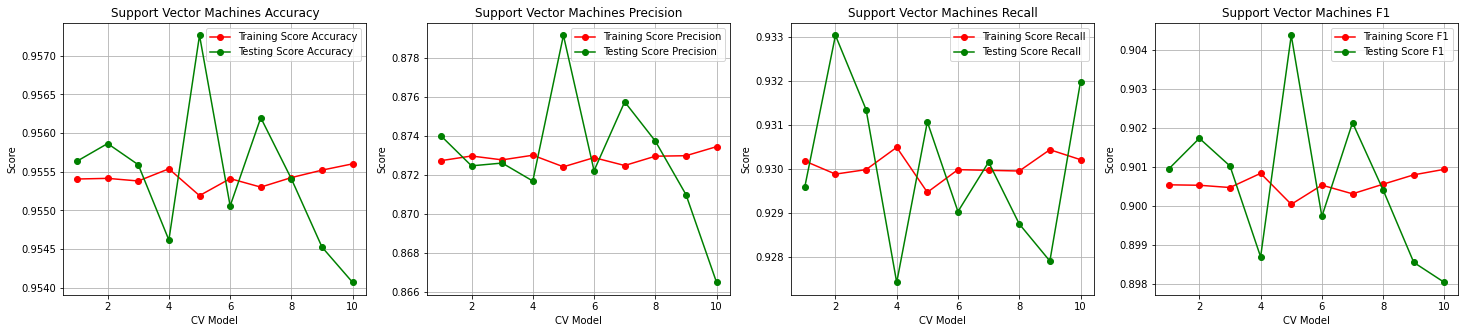

In [ ]:
from sklearn import svm

model = svm.SVC()

model = trainAndTestModel(model, 'Support Vector Machines', completeTrainingDataFrame, training_examples, training_targets, validation_targets)

XGBoost Model

'Cross validation XGBoost results:'

{'fit_time': array([16.7038765 , 15.98272681, 16.1133213 , 16.05624175, 16.02745461,
        16.10209775, 15.96652699, 16.01246166, 15.95913124, 15.87480617]),
 'score_time': array([0.18119669, 0.15757465, 0.16023779, 0.15532446, 0.15374041,
        0.15987611, 0.1726656 , 0.15467262, 0.15391922, 0.16045904]),
 'test_accuracy': array([0.95335281, 0.95402246, 0.95496606, 0.95380939, 0.95408264,
        0.95319991, 0.95472186, 0.95437181, 0.95406742, 0.95292596]),
 'test_f1': array([0.89799993, 0.89945752, 0.90152095, 0.89873544, 0.89915433,
        0.89766714, 0.90072413, 0.90009997, 0.89946702, 0.89732098]),
 'test_precision': array([0.85457309, 0.85601166, 0.85797542, 0.85734292, 0.85909555,
        0.8542564 , 0.85928944, 0.85757826, 0.8567168 , 0.85203631]),
 'test_recall': array([0.94607671, 0.94754926, 0.94972302, 0.94432758, 0.94313162,
        0.94572611, 0.9463572 , 0.94705841, 0.9467078 , 0.9476895 ]),
 'train_accuracy': array([0.95426382, 0.95416405, 0.95483708, 0.95389517, 0

XGBoost model testing metrics:
Accuracy: 0.953405
Precision: 0.856213
Recall: 0.945129
F1 score: 0.898476
Cohens kappa: 0.868336
ROC AUC: 0.950422
Confusion Matrix:
[[98193  4550]
 [ 1573 27094]]


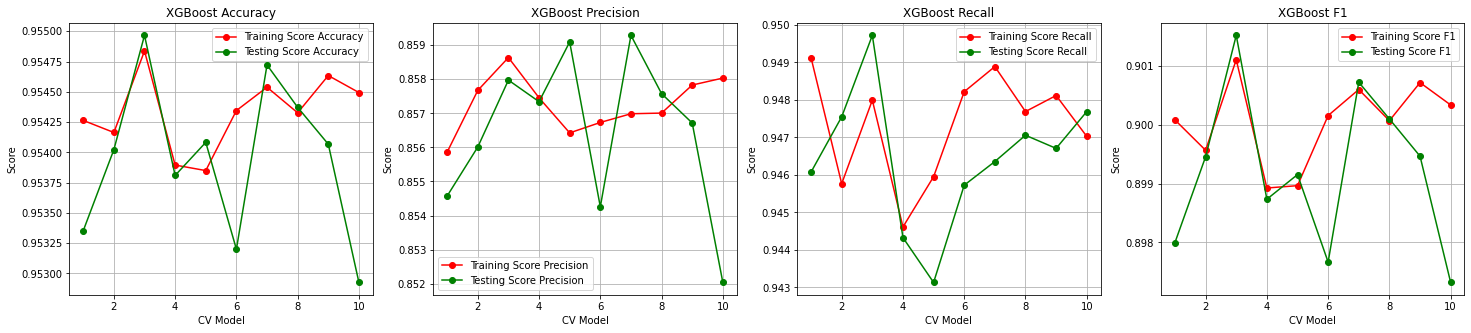

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()

model = trainAndTestModel(model, 'XGBoost', completeTrainingDataFrame, training_examples, training_targets, validation_targets)

Decision Tree Model

'Cross validation Decision Tree results:'

{'fit_time': array([1.7170465 , 1.67265058, 1.79653168, 1.81801724, 1.75710106,
        1.78615832, 1.64928317, 1.79595923, 1.87419128, 1.63049793]),
 'score_time': array([0.06554484, 0.06441689, 0.06538892, 0.06702757, 0.06476355,
        0.06512117, 0.06517339, 0.06204295, 0.06491446, 0.06605673]),
 'test_accuracy': array([0.94469303, 0.9434907 , 0.94353636, 0.94457127, 0.94435735,
        0.94292672, 0.94539228, 0.9455597 , 0.94333765, 0.94307891]),
 'test_f1': array([0.87248228, 0.86956827, 0.86980629, 0.87235385, 0.87088572,
        0.86822686, 0.87415825, 0.87426623, 0.86890383, 0.86954095]),
 'test_precision': array([0.87321767, 0.87125158, 0.87060063, 0.87210932, 0.87726788,
        0.87018384, 0.87446495, 0.87651537, 0.87268355, 0.865135  ]),
 'test_recall': array([0.87174812, 0.86789145, 0.86901339, 0.87259851, 0.86459575,
        0.86627866, 0.87385176, 0.87202861, 0.86515672, 0.87399201]),
 'train_accuracy': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'train_f1': arra

Decision Tree model testing metrics:
Accuracy: 0.943459
Precision: 0.869326
Recall: 0.871874
F1 score: 0.870598
Cohens kappa: 0.834425
ROC AUC: 0.917653
Confusion Matrix:
[[98986  3757]
 [ 3673 24994]]


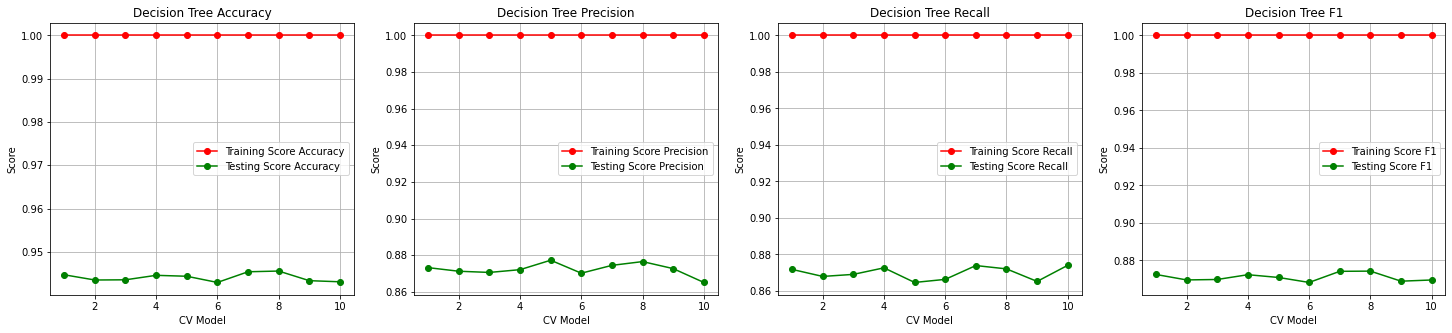

In [ ]:
from sklearn import tree
 
model = tree.DecisionTreeClassifier()
 
model = trainAndTestModel(model, 'Decision Tree', completeTrainingDataFrame, training_examples, training_targets, validation_targets)

Neural Network


In [ ]:
import keras

from sklearn.preprocessing import MinMaxScaler

model = keras.Sequential([keras.layers.Dense(2,activation = 'relu'),
                keras.layers.Dense(4,activation = 'relu'),
                keras.layers.Dense(4,activation = 'relu'),
                keras.layers.Dense(4,activation = 'relu'),                          
                keras.layers.Dense(1,activation = 'sigmoid')])
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics =[tf.keras.metrics.BinaryAccuracy()])

scaler = MinMaxScaler()

# Fit and Transform the data in one step
normalized_data = scaler.fit_transform(training_examples.values)

model.fit(normalized_data, training_targets.values.ravel(), batch_size=16, epochs = 20)

normalized_test_data = scaler.transform(validation_examples)

validation_predictions = model.predict_classes(normalized_test_data)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(validation_targets.values, validation_predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(validation_targets.values, validation_predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(validation_targets.values, validation_predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(validation_targets.values, validation_predictions)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(validation_targets.values,  validation_predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(validation_targets.values,  validation_predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(validation_targets.values,  validation_predictions)
print(matrix)

Epoch 1/20
525643/525643 [==============================] - 103s 195us/step - loss: 0.1754 - binary_accuracy: 0.8957
Epoch 2/20
525643/525643 [==============================] - 102s 194us/step - loss: 0.1432 - binary_accuracy: 0.9257
Epoch 3/20
525643/525643 [==============================] - 102s 194us/step - loss: 0.1419 - binary_accuracy: 0.9304
Epoch 4/20
525643/525643 [==============================] - 102s 194us/step - loss: 0.1418 - binary_accuracy: 0.9320
Epoch 5/20
525643/525643 [==============================] - 102s 195us/step - loss: 0.1416 - binary_accuracy: 0.9333
Epoch 6/20
525643/525643 [==============================] - 102s 194us/step - loss: 0.1415 - binary_accuracy: 0.9336
Epoch 7/20
525643/525643 [==============================] - 102s 195us/step - loss: 0.1415 - binary_accuracy: 0.9340
Epoch 8/20
525643/525643 [==============================] - 102s 195us/step - loss: 0.1414 - binary_accuracy: 0.9350
Epoch 9/20
525643/525643 [==============================] - 102s

Predicting and plotting classification of new unknown data.

In [ ]:
predictSample = pd.read_csv('/content/drive/MyDrive/date FACS/dateNoi/PAT 1 STIM isMonocyte.csv')

print("Test examples summary:")
display(predictSample.describe())
display(predictSample.head(10))

predictDataframe = predictSample[['FSC-A','SSC-A']]

validation_targets = model.predict(predictDataframe)

display(validation_targets)

Test examples summary:


,FSC-H,FSC-A,SSC-H,SSC-A,Violet SSC-H,Violet SSC-A,FSC-Width,TIME
count,49540.0,49540.0,49540.0,49540.0,49540.0,49540.0,49540.0,49540.0
mean,617157.9,709262.6,363874.4,417363.5,5611055.1,20986751.1,1185.9,3793871.1
std,81164.4,80774.8,126207.1,122032.6,30182.1,2482195.2,123.2,2147185.7
min,229327.3,500339.6,110524.7,194573.8,4058238.0,5710892.0,885.5,116.0
25%,571263.2,649627.0,269576.2,326391.9,5606043.8,19399957.5,1112.1,1913517.0
50%,625347.8,710719.5,329693.4,391106.0,5613630.5,21592315.0,1160.7,3809585.0
75%,673324.8,769334.1,432612.4,486653.3,5625848.0,22747587.5,1225.7,5655102.2
max,896954.7,901012.7,846554.9,854213.7,5668583.0,33098060.0,2466.4,7499933.0


,FSC-H,FSC-A,SSC-H,SSC-A,Violet SSC-H,Violet SSC-A,FSC-Width,TIME
0,663861.5,746154.0,417435.0,414622.2,5521646,21395800.0,1150.9,116
1,584609.5,632261.4,222210.0,243209.2,5509563,15380790.0,1107.5,478
2,519070.6,594637.7,437240.9,469004.7,5517957,21396460.0,1173.1,845
3,567618.5,628623.3,245267.9,246577.3,5532550,17360600.0,1134.1,929
4,719379.5,854303.4,349858.0,430573.8,5483568,22036870.0,1216.1,1539
5,579561.5,645208.0,381193.0,413307.1,5481357,20827200.0,1140.0,1542
6,619287.6,621220.2,291995.6,345740.4,5479806,20530090.0,1027.2,1560
7,676901.3,808155.3,699393.6,766380.5,5447639,21686160.0,1222.6,1596
8,671592.5,757185.8,309864.2,332020.2,5371783,22835850.0,1154.5,1855
9,635400.6,721856.0,352264.6,343041.1,5386944,21704370.0,1163.3,2524


array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,

Accuracy: 0.810638
Precision: 0.810638
Recall: 1.000000
F1 score: 0.895417
Cohens kappa: 0.000000
ROC AUC: 0.500000
[[    0  9381]
 [    0 40159]]
